# Noisy-And MIL

Now we're going to load and train and MIL network on MNIST (presence of 0 = positive bag).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import utils
from noisy_and import NoisyAnd
import mil_benchmarks

N_CLASSES = 2
MAX_BAG = 7

utils.gpu_fix()

tf.random.set_seed(42)
print(tf.__version__)

1 Physical GPUs, 1 Logical GPUs
2.4.1


In [3]:
def define_model(shape=(28, 28, 1)):
  model = tf.keras.Sequential([
    layers.Input((MAX_BAG,) + shape),
    *utils.baseline_layers(shape, N_CLASSES),
    NoisyAnd(N_CLASSES),
  ])

  utils.compile(model, N_CLASSES)
  return model

print(define_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 7, 28, 28, 64)     320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 14, 14, 64)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 12, 12, 32)     18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 7, 1152)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 256)            2

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7238 4794], test=[1199  803]
----------------
Epoch 1/10
188/188 [==============================] - 14s 50ms/step - loss: 0.5388 - precision: 0.6112 - recall: 0.9728 - auc: 0.6625 - f1: 0.3856 - tp: 5908.6349 - tn: 2697.9735 - fp: 3381.6878 - fn: 171.0265 - val_loss: 0.3855 - val_precision: 0.6967 - val_recall: 0.9960 - val_auc: 0.7207 - val_f1: 0.3759 - val_tp: 1994.0000 - val_tn: 1134.0000 - val_fp: 868.0000 - val_fn: 8.0000
Epoch 2/10
188/188 [==============================] - 7s 40ms/step - loss: 0.3707 - precision: 0.7064 - recall: 0.9904 - auc: 0.7353 - f1: 0.3896 - tp: 6021.7302 - tn: 3569.2487 - fp: 2510.4127 - fn: 57.9312 - val_loss: 0.3550 - val_precision: 0.7049 - val_recall: 0.9965 - val_auc: 0.8387 - val_f1: 0.4154 - val_tp: 1995.0000 - val_tn: 1167.0000 - val_fp: 835.0000 - val_fn: 7.0000
Epoch 3/10
188/188 [==============================] - 8s 40ms/st

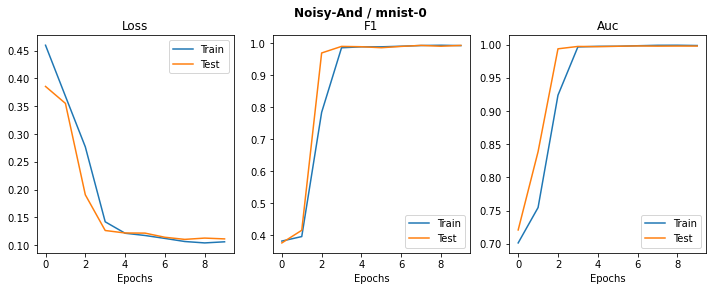

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[6724 5308], test=[1124  878]
----------------
Epoch 1/10
188/188 [==============================] - 10s 44ms/step - loss: 0.5354 - precision: 0.6055 - recall: 0.9836 - auc: 0.6406 - f1: 0.3651 - tp: 5977.6138 - tn: 2528.6402 - fp: 3551.0212 - fn: 102.0476 - val_loss: 0.3812 - val_precision: 0.6920 - val_recall: 0.9945 - val_auc: 0.6907 - val_f1: 0.4020 - val_tp: 1991.0000 - val_tn: 1116.0000 - val_fp: 886.0000 - val_fn: 11.0000
Epoch 2/10
188/188 [==============================] - 7s 39ms/step - loss: 0.4066 - precision: 0.6792 - recall: 0.9919 - auc: 0.7207 - f1: 0.4036 - tp: 6032.1799 - tn: 3245.4762 - fp: 2834.1852 - fn: 47.4815 - val_loss: 0.3406 - val_precision: 0.7013 - val_recall: 0.9955 - val_auc: 0.8320 - val_f1: 0.5820 - val_tp: 1993.0000 - val_tn: 1153.0000 - val_fp: 849.0000 - val_fn: 9.0000
Epoch 3/10
188/188 [==============================] - 7s 40ms/s

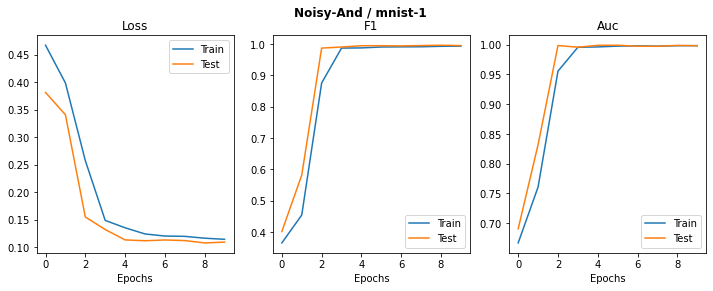

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7194 4838], test=[1179  823]
----------------
Epoch 1/10
188/188 [==============================] - 11s 45ms/step - loss: 0.5755 - precision: 0.5838 - recall: 0.9716 - auc: 0.6447 - f1: 0.3924 - tp: 5877.8836 - tn: 2298.6667 - fp: 3780.9947 - fn: 201.7778 - val_loss: 0.4239 - val_precision: 0.6994 - val_recall: 0.9705 - val_auc: 0.7116 - val_f1: 0.3759 - val_tp: 1943.0000 - val_tn: 1167.0000 - val_fp: 835.0000 - val_fn: 59.0000
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.3958 - precision: 0.6958 - recall: 0.9844 - auc: 0.7333 - f1: 0.3954 - tp: 5990.8730 - tn: 3457.1164 - fp: 2622.5450 - fn: 88.7884 - val_loss: 0.3767 - val_precision: 0.6968 - val_recall: 0.9850 - val_auc: 0.8404 - val_f1: 0.5643 - val_tp: 1972.0000 - val_tn: 1144.0000 - val_fp: 858.0000 - val_fn: 30.0000
Epoch 3/10
188/188 [==============================] - 8s 42ms/

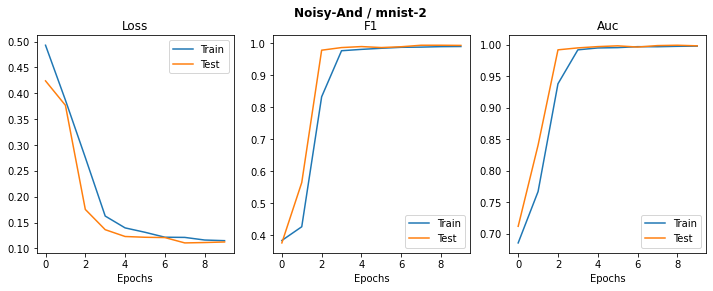

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7147 4885], test=[1198  804]
----------------
Epoch 1/10
188/188 [==============================] - 10s 44ms/step - loss: 0.6061 - precision: 0.5614 - recall: 0.9736 - auc: 0.6189 - f1: 0.4340 - tp: 5878.4286 - tn: 1861.8201 - fp: 4217.8413 - fn: 201.2328 - val_loss: 0.3994 - val_precision: 0.7025 - val_recall: 0.9850 - val_auc: 0.7183 - val_f1: 0.3784 - val_tp: 1972.0000 - val_tn: 1167.0000 - val_fp: 835.0000 - val_fn: 30.0000
Epoch 2/10
188/188 [==============================] - 8s 40ms/step - loss: 0.4200 - precision: 0.6900 - recall: 0.9737 - auc: 0.7121 - f1: 0.3775 - tp: 5935.7513 - tn: 3427.5185 - fp: 2652.1429 - fn: 143.9101 - val_loss: 0.3670 - val_precision: 0.7058 - val_recall: 0.9885 - val_auc: 0.7201 - val_f1: 0.3784 - val_tp: 1979.0000 - val_tn: 1177.0000 - val_fp: 825.0000 - val_fn: 23.0000
Epoch 3/10
188/188 [==============================] - 7s 40ms

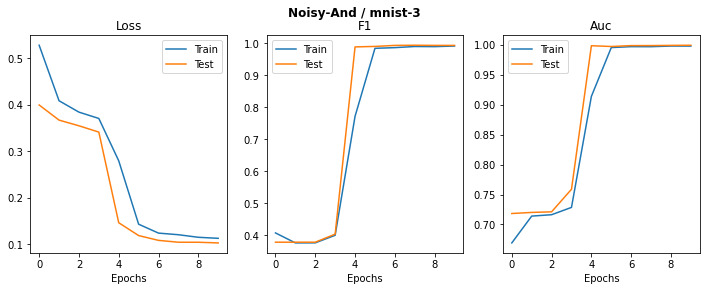

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7292 4740], test=[1216  786]
----------------
Epoch 1/10
188/188 [==============================] - 11s 47ms/step - loss: 0.5708 - precision: 0.5823 - recall: 0.9737 - auc: 0.6568 - f1: 0.4027 - tp: 5900.3280 - tn: 2276.0370 - fp: 3803.6243 - fn: 179.3333 - val_loss: 0.3619 - val_precision: 0.7094 - val_recall: 0.9915 - val_auc: 0.7293 - val_f1: 0.3848 - val_tp: 1985.0000 - val_tn: 1189.0000 - val_fp: 813.0000 - val_fn: 17.0000
Epoch 2/10
188/188 [==============================] - 7s 40ms/step - loss: 0.3656 - precision: 0.7098 - recall: 0.9896 - auc: 0.7406 - f1: 0.3920 - tp: 6017.9312 - tn: 3600.8095 - fp: 2478.8519 - fn: 61.7302 - val_loss: 0.3393 - val_precision: 0.7105 - val_recall: 0.9965 - val_auc: 0.8463 - val_f1: 0.4156 - val_tp: 1995.0000 - val_tn: 1189.0000 - val_fp: 813.0000 - val_fn: 7.0000
Epoch 3/10
188/188 [==============================] - 7s 40ms/s

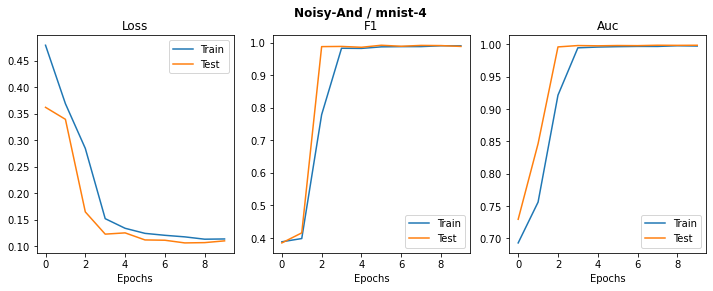

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7564 4468], test=[1264  738]
----------------
Epoch 1/10
188/188 [==============================] - 10s 45ms/step - loss: 0.6102 - precision: 0.5565 - recall: 0.9635 - auc: 0.6609 - f1: 0.4044 - tp: 5834.7513 - tn: 1845.8254 - fp: 4233.8360 - fn: 244.9101 - val_loss: 0.3785 - val_precision: 0.7006 - val_recall: 0.9925 - val_auc: 0.7458 - val_f1: 0.3929 - val_tp: 1987.0000 - val_tn: 1153.0000 - val_fp: 849.0000 - val_fn: 15.0000
Epoch 2/10
188/188 [==============================] - 7s 40ms/step - loss: 0.3694 - precision: 0.7114 - recall: 0.9843 - auc: 0.7467 - f1: 0.3903 - tp: 5988.6455 - tn: 3670.0370 - fp: 2409.6243 - fn: 91.0159 - val_loss: 0.3412 - val_precision: 0.7150 - val_recall: 0.9950 - val_auc: 0.7716 - val_f1: 0.4073 - val_tp: 1992.0000 - val_tn: 1208.0000 - val_fp: 794.0000 - val_fn: 10.0000
Epoch 3/10
188/188 [==============================] - 8s 40ms/

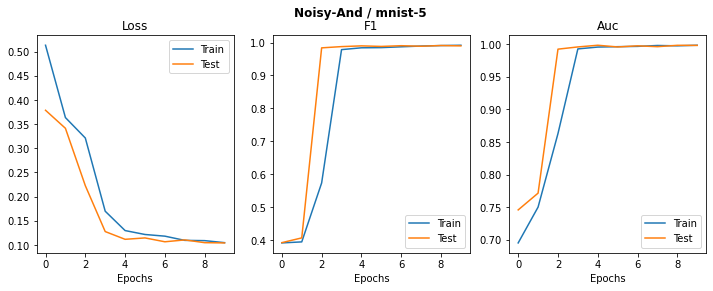

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7226 4806], test=[1219  783]
----------------
Epoch 1/10
188/188 [==============================] - 11s 45ms/step - loss: 0.5184 - precision: 0.6169 - recall: 0.9805 - auc: 0.6675 - f1: 0.3810 - tp: 5955.5926 - tn: 2794.6931 - fp: 3284.9683 - fn: 124.0688 - val_loss: 0.3591 - val_precision: 0.7128 - val_recall: 0.9920 - val_auc: 0.7307 - val_f1: 0.3812 - val_tp: 1986.0000 - val_tn: 1202.0000 - val_fp: 800.0000 - val_fn: 16.0000
Epoch 2/10
188/188 [==============================] - 7s 40ms/step - loss: 0.3712 - precision: 0.7008 - recall: 0.9928 - auc: 0.7392 - f1: 0.4053 - tp: 6031.7989 - tn: 3506.1111 - fp: 2573.5503 - fn: 47.8624 - val_loss: 0.3352 - val_precision: 0.7159 - val_recall: 0.9905 - val_auc: 0.8561 - val_f1: 0.5556 - val_tp: 1983.0000 - val_tn: 1215.0000 - val_fp: 787.0000 - val_fn: 19.0000
Epoch 3/10
188/188 [==============================] - 7s 40ms/

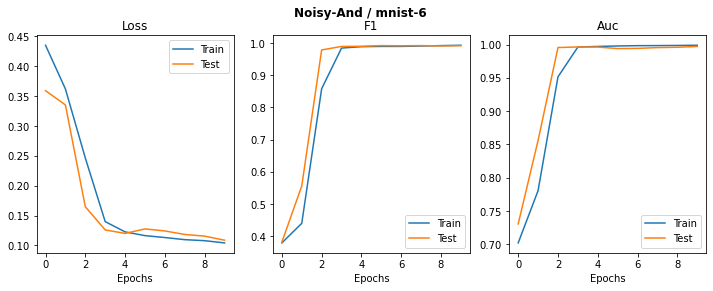

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7023 5009], test=[1157  845]
----------------
Epoch 1/10
188/188 [==============================] - 10s 45ms/step - loss: 0.5565 - precision: 0.6031 - recall: 0.9732 - auc: 0.6534 - f1: 0.4011 - tp: 5906.4974 - tn: 2552.2910 - fp: 3527.3704 - fn: 173.1640 - val_loss: 0.4252 - val_precision: 0.6825 - val_recall: 0.9835 - val_auc: 0.7017 - val_f1: 0.3714 - val_tp: 1969.0000 - val_tn: 1086.0000 - val_fp: 916.0000 - val_fn: 33.0000
Epoch 2/10
188/188 [==============================] - 8s 41ms/step - loss: 0.4109 - precision: 0.6835 - recall: 0.9856 - auc: 0.7147 - f1: 0.3865 - tp: 5997.4444 - tn: 3323.4444 - fp: 2756.2169 - fn: 82.2169 - val_loss: 0.3782 - val_precision: 0.6900 - val_recall: 0.9930 - val_auc: 0.8282 - val_f1: 0.5382 - val_tp: 1988.0000 - val_tn: 1109.0000 - val_fp: 893.0000 - val_fn: 14.0000
Epoch 3/10
188/188 [==============================] - 8s 40ms/

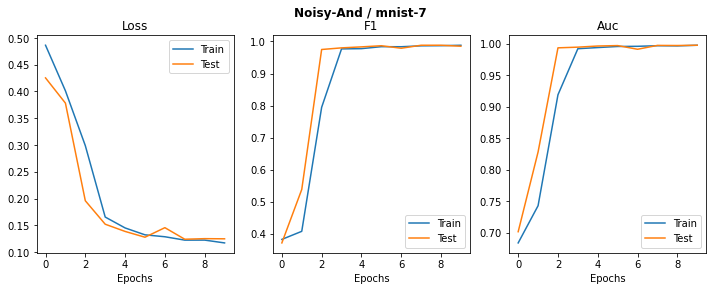

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7264 4768], test=[1221  781]
----------------
Epoch 1/10
188/188 [==============================] - 11s 45ms/step - loss: 0.6438 - precision: 0.5354 - recall: 0.9740 - auc: 0.6220 - f1: 0.3813 - tp: 5880.0317 - tn: 1309.4497 - fp: 4770.2116 - fn: 199.6296 - val_loss: 0.4659 - val_precision: 0.6460 - val_recall: 0.9965 - val_auc: 0.7223 - val_f1: 0.3899 - val_tp: 1995.0000 - val_tn: 909.0000 - val_fp: 1093.0000 - val_fn: 7.0000
Epoch 2/10
188/188 [==============================] - 8s 40ms/step - loss: 0.4332 - precision: 0.6814 - recall: 0.9728 - auc: 0.7179 - f1: 0.3806 - tp: 5916.1164 - tn: 3374.8148 - fp: 2704.8466 - fn: 163.5450 - val_loss: 0.3707 - val_precision: 0.7098 - val_recall: 0.9785 - val_auc: 0.7311 - val_f1: 0.3802 - val_tp: 1959.0000 - val_tn: 1201.0000 - val_fp: 801.0000 - val_fn: 43.0000
Epoch 3/10
188/188 [==============================] - 8s 41ms/

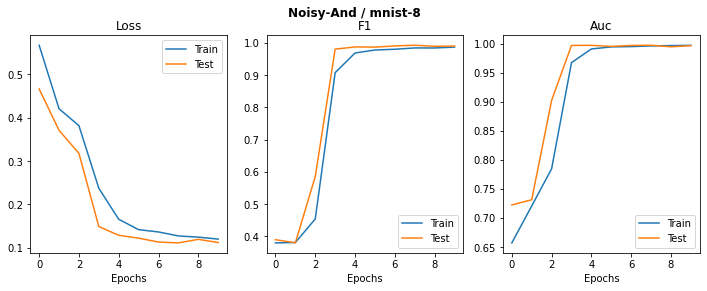

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7244 4788], test=[1184  818]
----------------
Epoch 1/10
188/188 [==============================] - 10s 45ms/step - loss: 0.5842 - precision: 0.5749 - recall: 0.9702 - auc: 0.6529 - f1: 0.4019 - tp: 5867.6455 - tn: 2119.6085 - fp: 3960.0529 - fn: 212.0159 - val_loss: 0.4210 - val_precision: 0.6880 - val_recall: 0.9790 - val_auc: 0.7300 - val_f1: 0.3940 - val_tp: 1960.0000 - val_tn: 1113.0000 - val_fp: 889.0000 - val_fn: 42.0000
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.4181 - precision: 0.6852 - recall: 0.9785 - auc: 0.7577 - f1: 0.4166 - tp: 5950.2963 - tn: 3348.0635 - fp: 2731.5979 - fn: 129.3651 - val_loss: 0.3646 - val_precision: 0.6984 - val_recall: 0.9845 - val_auc: 0.8622 - val_f1: 0.5936 - val_tp: 1971.0000 - val_tn: 1151.0000 - val_fp: 851.0000 - val_fn: 31.0000
Epoch 3/10
188/188 [==============================] - 7s 40ms

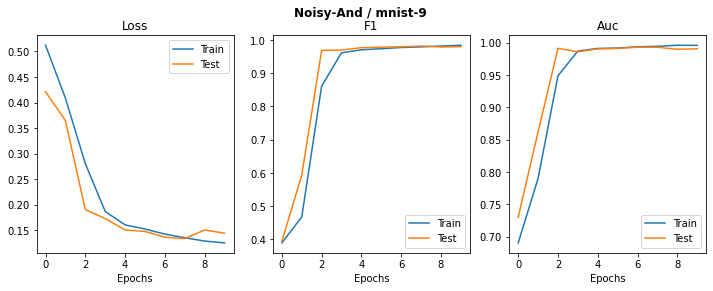

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7208 4824], test=[1193  809]
----------------
Epoch 1/10
188/188 [==============================] - 12s 50ms/step - loss: 0.5842 - precision: 0.5779 - recall: 0.9622 - auc: 0.6592 - f1: 0.3813 - tp: 5829.8307 - tn: 2164.6508 - fp: 3915.0106 - fn: 249.8307 - val_loss: 0.4652 - val_precision: 0.6587 - val_recall: 0.9630 - val_auc: 0.7082 - val_f1: 0.3881 - val_tp: 1928.0000 - val_tn: 1003.0000 - val_fp: 999.0000 - val_fn: 74.0000
Epoch 2/10
188/188 [==============================] - 8s 41ms/step - loss: 0.4729 - precision: 0.6446 - recall: 0.9706 - auc: 0.7276 - f1: 0.4173 - tp: 5910.0688 - tn: 2841.5820 - fp: 3238.0794 - fn: 169.5926 - val_loss: 0.4372 - val_precision: 0.6519 - val_recall: 0.9820 - val_auc: 0.8321 - val_f1: 0.6361 - val_tp: 1966.0000 - val_tn: 952.0000 - val_fp: 1050.0000 - val_fn: 36.0000
Epoch 3/10
188/188 [==============================] - 8s 41ms

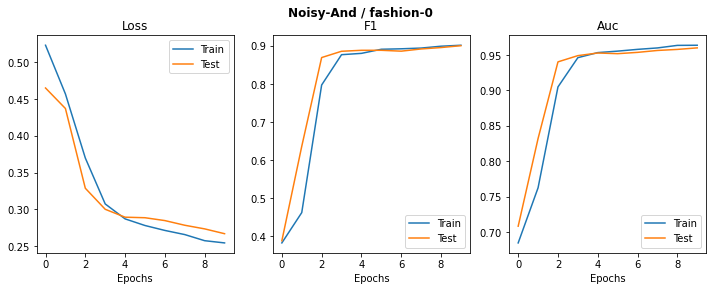

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7187 4845], test=[1196  806]
----------------
Epoch 1/10
188/188 [==============================] - 10s 45ms/step - loss: 0.5314 - precision: 0.6085 - recall: 0.9787 - auc: 0.6696 - f1: 0.3935 - tp: 5945.0847 - tn: 2620.2487 - fp: 3459.4127 - fn: 134.5767 - val_loss: 0.3743 - val_precision: 0.7080 - val_recall: 0.9870 - val_auc: 0.7195 - val_f1: 0.3780 - val_tp: 1976.0000 - val_tn: 1187.0000 - val_fp: 815.0000 - val_fn: 26.0000
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.3774 - precision: 0.7023 - recall: 0.9882 - auc: 0.7382 - f1: 0.4081 - tp: 6008.1058 - tn: 3530.6772 - fp: 2548.9841 - fn: 71.5556 - val_loss: 0.3439 - val_precision: 0.7050 - val_recall: 0.9930 - val_auc: 0.8489 - val_f1: 0.5779 - val_tp: 1988.0000 - val_tn: 1170.0000 - val_fp: 832.0000 - val_fn: 14.0000
Epoch 3/10
188/188 [==============================] - 8s 41ms/

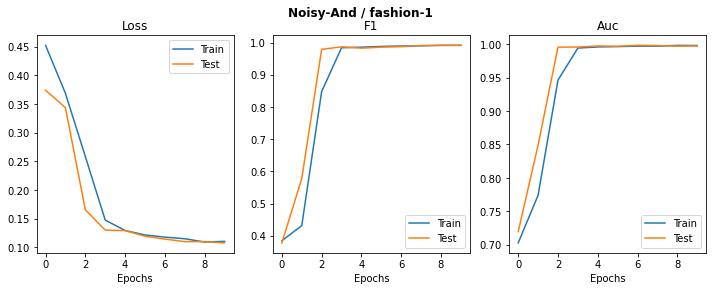

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7220 4812], test=[1190  812]
----------------
Epoch 1/10
188/188 [==============================] - 13s 58ms/step - loss: 0.6079 - precision: 0.5509 - recall: 0.9695 - auc: 0.6500 - f1: 0.4124 - tp: 5867.0212 - tn: 1537.9735 - fp: 4541.6878 - fn: 212.6402 - val_loss: 0.5254 - val_precision: 0.5989 - val_recall: 0.9785 - val_auc: 0.7011 - val_f1: 0.4085 - val_tp: 1959.0000 - val_tn: 690.0000 - val_fp: 1312.0000 - val_fn: 43.0000
Epoch 2/10
188/188 [==============================] - 9s 46ms/step - loss: 0.5188 - precision: 0.6056 - recall: 0.9670 - auc: 0.7282 - f1: 0.4450 - tp: 5875.8836 - tn: 2279.7407 - fp: 3799.9206 - fn: 203.7778 - val_loss: 0.4868 - val_precision: 0.6277 - val_recall: 0.9710 - val_auc: 0.8087 - val_f1: 0.6026 - val_tp: 1944.0000 - val_tn: 849.0000 - val_fp: 1153.0000 - val_fn: 58.0000
Epoch 3/10
188/188 [==============================] - 8s 45ms

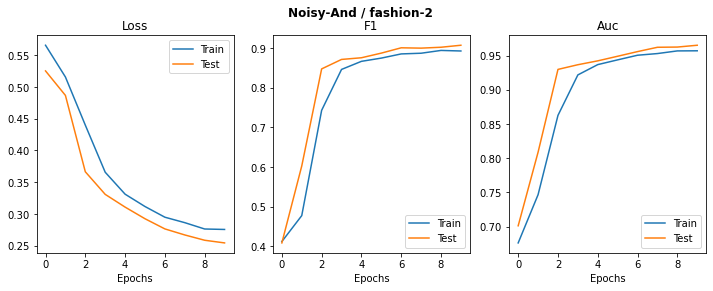

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7153 4879], test=[1199  803]
----------------
Epoch 1/10
188/188 [==============================] - 12s 53ms/step - loss: 0.6107 - precision: 0.5407 - recall: 0.9827 - auc: 0.6548 - f1: 0.4586 - tp: 5966.5873 - tn: 1212.1640 - fp: 4867.4974 - fn: 113.0741 - val_loss: 0.5466 - val_precision: 0.5842 - val_recall: 0.9700 - val_auc: 0.6963 - val_f1: 0.4165 - val_tp: 1942.0000 - val_tn: 620.0000 - val_fp: 1382.0000 - val_fn: 60.0000
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.5258 - precision: 0.5941 - recall: 0.9776 - auc: 0.7255 - f1: 0.4695 - tp: 5939.2328 - tn: 2149.7778 - fp: 3929.8836 - fn: 140.4286 - val_loss: 0.4474 - val_precision: 0.6587 - val_recall: 0.9715 - val_auc: 0.8171 - val_f1: 0.5640 - val_tp: 1945.0000 - val_tn: 994.0000 - val_fp: 1008.0000 - val_fn: 57.0000 - recall: 0.9
Epoch 3/10
188/188 [===========================

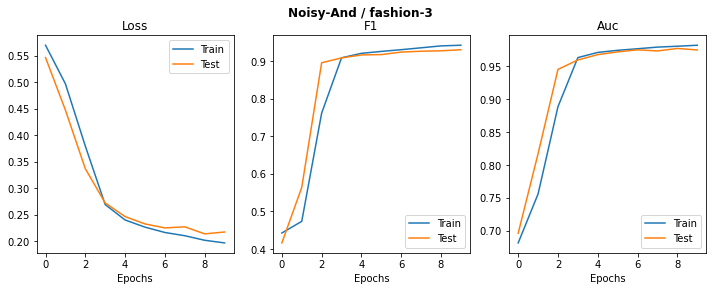

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7235 4797], test=[1194  808]
----------------
Epoch 1/10
188/188 [==============================] - 11s 48ms/step - loss: 0.6207 - precision: 0.5463 - recall: 0.9721 - auc: 0.6308 - f1: 0.4030 - tp: 5873.1005 - tn: 1478.6772 - fp: 4600.9841 - fn: 206.5608 - val_loss: 0.5150 - val_precision: 0.6001 - val_recall: 0.9835 - val_auc: 0.7012 - val_f1: 0.4065 - val_tp: 1969.0000 - val_tn: 690.0000 - val_fp: 1312.0000 - val_fn: 33.0000
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.5034 - precision: 0.6224 - recall: 0.9685 - auc: 0.7170 - f1: 0.4197 - tp: 5887.8677 - tn: 2526.4921 - fp: 3553.1693 - fn: 191.7937 - val_loss: 0.4860 - val_precision: 0.6130 - val_recall: 0.9865 - val_auc: 0.8080 - val_f1: 0.6058 - val_tp: 1975.0000 - val_tn: 755.0000 - val_fp: 1247.0000 - val_fn: 27.0000
Epoch 3/10
188/188 [==============================] - 8s 42ms

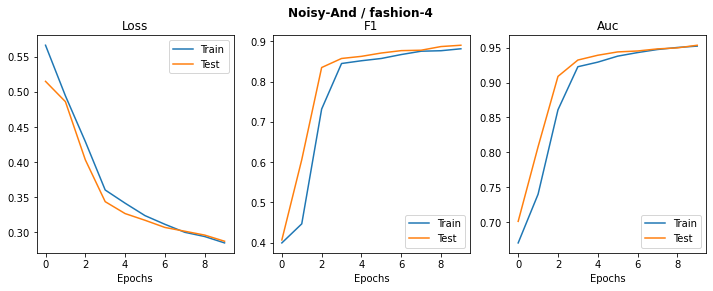

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7181 4851], test=[1208  794]
----------------
Epoch 1/10
188/188 [==============================] - 11s 46ms/step - loss: 0.5626 - precision: 0.5781 - recall: 0.9757 - auc: 0.6580 - f1: 0.3943 - tp: 5921.0476 - tn: 2128.9365 - fp: 3950.7249 - fn: 158.6138 - val_loss: 0.3929 - val_precision: 0.6905 - val_recall: 0.9795 - val_auc: 0.7226 - val_f1: 0.3818 - val_tp: 1961.0000 - val_tn: 1123.0000 - val_fp: 879.0000 - val_fn: 41.0000
Epoch 2/10
188/188 [==============================] - 8s 44ms/step - loss: 0.4011 - precision: 0.6844 - recall: 0.9850 - auc: 0.7256 - f1: 0.3880 - tp: 5991.7196 - tn: 3327.1323 - fp: 2752.5291 - fn: 87.9418 - val_loss: 0.3590 - val_precision: 0.6983 - val_recall: 0.9885 - val_auc: 0.8478 - val_f1: 0.5684 - val_tp: 1979.0000 - val_tn: 1147.0000 - val_fp: 855.0000 - val_fn: 23.0000
Epoch 3/10
188/188 [==============================] - 7s 40ms/

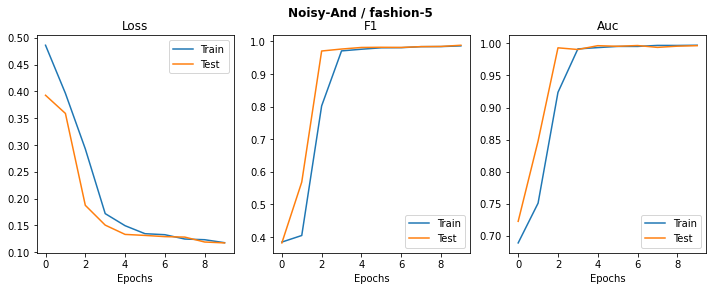

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7204 4828], test=[1190  812]
----------------
Epoch 1/10
188/188 [==============================] - 11s 48ms/step - loss: 0.6447 - precision: 0.5283 - recall: 0.9626 - auc: 0.6313 - f1: 0.3924 - tp: 5800.9365 - tn: 1088.0794 - fp: 4991.5820 - fn: 278.7249 - val_loss: 0.6052 - val_precision: 0.5859 - val_recall: 0.9266 - val_auc: 0.6731 - val_f1: 0.3901 - val_tp: 1855.0000 - val_tn: 691.0000 - val_fp: 1311.0000 - val_fn: 147.0000
Epoch 2/10
188/188 [==============================] - 8s 42ms/step - loss: 0.5882 - precision: 0.5791 - recall: 0.9479 - auc: 0.6861 - f1: 0.4164 - tp: 5775.8307 - tn: 1858.4392 - fp: 4221.2222 - fn: 303.8307 - val_loss: 0.5719 - val_precision: 0.5707 - val_recall: 0.9675 - val_auc: 0.7601 - val_f1: 0.5689 - val_tp: 1937.0000 - val_tn: 545.0000 - val_fp: 1457.0000 - val_fn: 65.0000
Epoch 3/10
188/188 [==============================] - 8s 41m

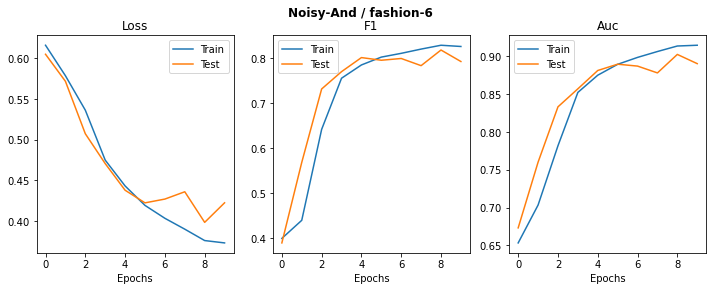

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7171 4861], test=[1206  796]
----------------
Epoch 1/10
188/188 [==============================] - 13s 47ms/step - loss: 0.5591 - precision: 0.5783 - recall: 0.9828 - auc: 0.6694 - f1: 0.4054 - tp: 5974.6825 - tn: 1970.4233 - fp: 4109.2381 - fn: 104.9788 - val_loss: 0.4306 - val_precision: 0.6522 - val_recall: 0.9940 - val_auc: 0.7246 - val_f1: 0.4002 - val_tp: 1990.0000 - val_tn: 941.0000 - val_fp: 1061.0000 - val_fn: 12.0000
Epoch 2/10
188/188 [==============================] - 8s 41ms/step - loss: 0.4191 - precision: 0.6745 - recall: 0.9819 - auc: 0.7435 - f1: 0.4030 - tp: 5970.9101 - tn: 3194.6032 - fp: 2885.0582 - fn: 108.7513 - val_loss: 0.3626 - val_precision: 0.6882 - val_recall: 0.9955 - val_auc: 0.8562 - val_f1: 0.6052 - val_tp: 1993.0000 - val_tn: 1099.0000 - val_fp: 903.0000 - val_fn: 9.0000
Epoch 3/10
188/188 [==============================] - 8s 44ms/

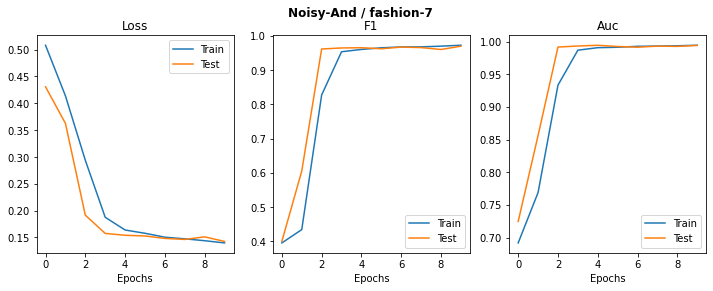

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7196 4836], test=[1188  814]
----------------
Epoch 1/10
188/188 [==============================] - 12s 50ms/step - loss: 0.5815 - precision: 0.5853 - recall: 0.9675 - auc: 0.6512 - f1: 0.4107 - tp: 5852.5185 - tn: 2343.8413 - fp: 3735.8201 - fn: 227.1429 - val_loss: 0.4057 - val_precision: 0.6953 - val_recall: 0.9880 - val_auc: 0.7143 - val_f1: 0.3738 - val_tp: 1978.0000 - val_tn: 1135.0000 - val_fp: 867.0000 - val_fn: 24.0000
Epoch 2/10
188/188 [==============================] - 8s 41ms/step - loss: 0.3987 - precision: 0.7011 - recall: 0.9847 - auc: 0.7204 - f1: 0.3776 - tp: 5990.2751 - tn: 3528.8624 - fp: 2550.7989 - fn: 89.3862 - val_loss: 0.3839 - val_precision: 0.7003 - val_recall: 0.9875 - val_auc: 0.7362 - val_f1: 0.4013 - val_tp: 1977.0000 - val_tn: 1156.0000 - val_fp: 846.0000 - val_fn: 25.0000
Epoch 3/10
188/188 [==============================] - 8s 40ms/

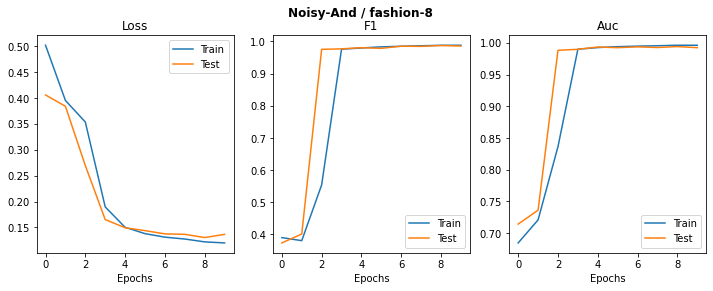

----- Data -----
Train : x=(12032, 7, 28, 28, 1), y=(12032, 2)
Test  : x=(2002, 7, 28, 28, 1), y=(2002, 2)
Splits: train=[7130 4902], test=[1192  810]
----------------
Epoch 1/10
188/188 [==============================] - 10s 45ms/step - loss: 0.5135 - precision: 0.6156 - recall: 0.9822 - auc: 0.6707 - f1: 0.3858 - tp: 5974.4339 - tn: 2699.5873 - fp: 3380.0741 - fn: 105.2275 - val_loss: 0.3951 - val_precision: 0.6784 - val_recall: 0.9935 - val_auc: 0.7185 - val_f1: 0.3996 - val_tp: 1989.0000 - val_tn: 1059.0000 - val_fp: 943.0000 - val_fn: 13.0000
Epoch 2/10
188/188 [==============================] - 8s 41ms/step - loss: 0.3886 - precision: 0.6846 - recall: 0.9912 - auc: 0.7502 - f1: 0.4127 - tp: 6025.1111 - tn: 3309.0794 - fp: 2770.5820 - fn: 54.5503 - val_loss: 0.3508 - val_precision: 0.6943 - val_recall: 0.9915 - val_auc: 0.8816 - val_f1: 0.6032 - val_tp: 1985.0000 - val_tn: 1128.0000 - val_fp: 874.0000 - val_fn: 17.0000
Epoch 3/10
188/188 [==============================] - 8s 41ms/

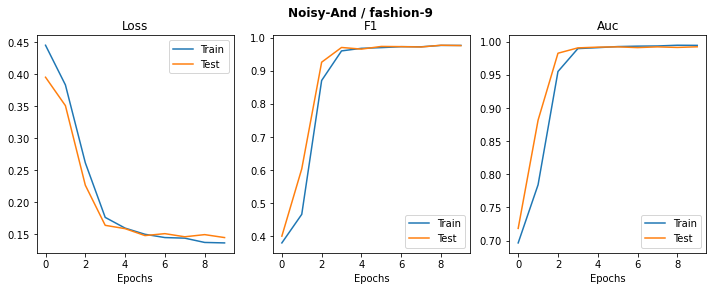

----- Data -----
Train : x=(10036, 7, 32, 32, 3), y=(10036, 2)
Test  : x=(2002, 7, 32, 32, 3), y=(2002, 2)
Splits: train=[5987 4049], test=[1197  805]
----------------
Epoch 1/10
157/157 [==============================] - 16s 72ms/step - loss: 0.6637 - precision: 0.5209 - recall: 0.9676 - auc: 0.6019 - f1: 0.3899 - tp: 4876.6835 - tn: 725.7089 - fp: 4361.7342 - fn: 210.7595 - val_loss: 0.6023 - val_precision: 0.5855 - val_recall: 0.9251 - val_auc: 0.6656 - val_f1: 0.3809 - val_tp: 1852.0000 - val_tn: 691.0000 - val_fp: 1311.0000 - val_fn: 150.0000
Epoch 2/10
157/157 [==============================] - 9s 60ms/step - loss: 0.6140 - precision: 0.5638 - recall: 0.9381 - auc: 0.6615 - f1: 0.4062 - tp: 4773.7532 - tn: 1345.8544 - fp: 3741.5886 - fn: 313.6899 - val_loss: 0.5945 - val_precision: 0.6052 - val_recall: 0.8966 - val_auc: 0.6796 - val_f1: 0.3890 - val_tp: 1795.0000 - val_tn: 831.0000 - val_fp: 1171.0000 - val_fn: 207.0000
Epoch 3/10
157/157 [==============================] - 10s 61

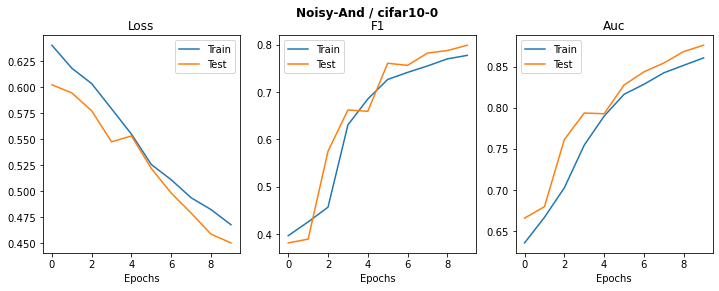

----- Data -----
Train : x=(10036, 7, 32, 32, 3), y=(10036, 2)
Test  : x=(2002, 7, 32, 32, 3), y=(2002, 2)
Splits: train=[5974 4062], test=[1210  792]
----------------
Epoch 1/10
157/157 [==============================] - 19s 68ms/step - loss: 0.6687 - precision: 0.5145 - recall: 0.9729 - auc: 0.6107 - f1: 0.3860 - tp: 4920.7215 - tn: 500.8101 - fp: 4586.6329 - fn: 166.7215 - val_loss: 0.6251 - val_precision: 0.5258 - val_recall: 0.9910 - val_auc: 0.7184 - val_f1: 0.5496 - val_tp: 1984.0000 - val_tn: 213.0000 - val_fp: 1789.0000 - val_fn: 18.0000
Epoch 2/10
157/157 [==============================] - 9s 59ms/step - loss: 0.6189 - precision: 0.5535 - recall: 0.9446 - auc: 0.6753 - f1: 0.4644 - tp: 4797.5316 - tn: 1288.4177 - fp: 3799.0253 - fn: 289.9114 - val_loss: 0.5910 - val_precision: 0.5529 - val_recall: 0.9860 - val_auc: 0.7522 - val_f1: 0.5600 - val_tp: 1974.0000 - val_tn: 406.0000 - val_fp: 1596.0000 - val_fn: 28.0000
Epoch 3/10
157/157 [==============================] - 9s 60ms/

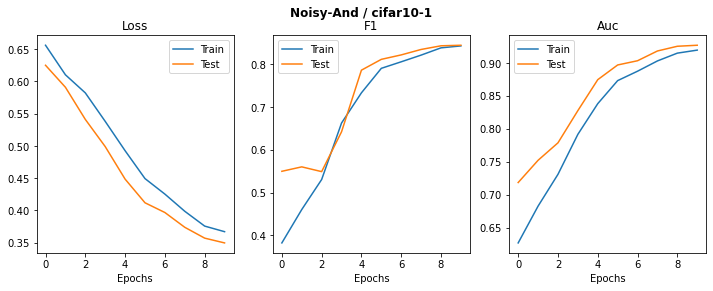

----- Data -----
Train : x=(10036, 7, 32, 32, 3), y=(10036, 2)
Test  : x=(2002, 7, 32, 32, 3), y=(2002, 2)
Splits: train=[6035 4001], test=[1220  782]
----------------
Epoch 1/10
157/157 [==============================] - 14s 70ms/step - loss: 0.6770 - precision: 0.5083 - recall: 0.9740 - auc: 0.6060 - f1: 0.3832 - tp: 4920.1582 - tn: 379.8608 - fp: 4707.5823 - fn: 167.2848 - val_loss: 0.6508 - val_precision: 0.5181 - val_recall: 0.9780 - val_auc: 0.6400 - val_f1: 0.3786 - val_tp: 1958.0000 - val_tn: 181.0000 - val_fp: 1821.0000 - val_fn: 44.0000
Epoch 2/10
157/157 [==============================] - 10s 61ms/step - loss: 0.6502 - precision: 0.5341 - recall: 0.9389 - auc: 0.6373 - f1: 0.3777 - tp: 4790.7152 - tn: 886.8354 - fp: 4200.6076 - fn: 296.7278 - val_loss: 0.6499 - val_precision: 0.5110 - val_recall: 0.9955 - val_auc: 0.6488 - val_f1: 0.3786 - val_tp: 1993.0000 - val_tn: 95.0000 - val_fp: 1907.0000 - val_fn: 9.0000
Epoch 3/10
157/157 [==============================] - 10s 64ms/s

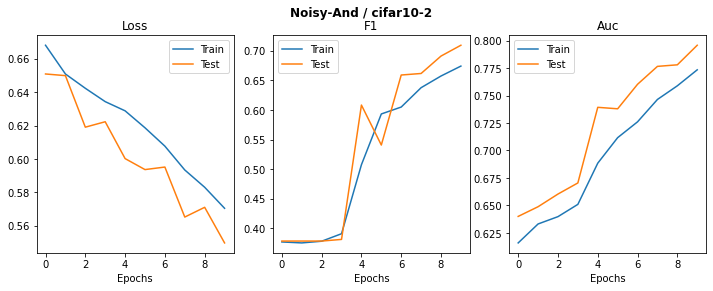

----- Data -----
Train : x=(10036, 7, 32, 32, 3), y=(10036, 2)
Test  : x=(2002, 7, 32, 32, 3), y=(2002, 2)
Splits: train=[5996 4040], test=[1187  815]
----------------
Epoch 1/10
157/157 [==============================] - 14s 72ms/step - loss: 0.6746 - precision: 0.5104 - recall: 0.9734 - auc: 0.5880 - f1: 0.4443 - tp: 4909.5949 - tn: 451.0633 - fp: 4636.3797 - fn: 177.8481 - val_loss: 0.6537 - val_precision: 0.5156 - val_recall: 0.9810 - val_auc: 0.6375 - val_f1: 0.3836 - val_tp: 1964.0000 - val_tn: 157.0000 - val_fp: 1845.0000 - val_fn: 38.0000
Epoch 2/10
157/157 [==============================] - 10s 61ms/step - loss: 0.6453 - precision: 0.5362 - recall: 0.9455 - auc: 0.6376 - f1: 0.3815 - tp: 4802.1899 - tn: 935.8481 - fp: 4151.5949 - fn: 285.2532 - val_loss: 0.6422 - val_precision: 0.5552 - val_recall: 0.9066 - val_auc: 0.6367 - val_f1: 0.3720 - val_tp: 1815.0000 - val_tn: 548.0000 - val_fp: 1454.0000 - val_fn: 187.0000
Epoch 3/10
157/157 [==============================] - 9s 60ms

In [ ]:
standard_mnist   = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.standard.mnist)
standard_fashion = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.standard.fashion)
standard_cifar10 = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.standard.cifar10, (32, 32, 3))

In [ ]:
presence_mnist   = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.presence.mnist)
presence_fashion = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.presence.fashion)
presence_cifar10 = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.presence.cifar10, (32, 32, 3))

In [ ]:
absence_mnist   = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.absence.mnist)
absence_fashion = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.absence.fashion)
absence_cifar10 = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.absence.cifar10, (32, 32, 3))

In [ ]:
complex_fashion = utils.evaluate_all(define_model, 'Noisy-And', mil_benchmarks.complex.fashion)

In [ ]:
utils.plot_histories(standard_mnist, title='Standard MNIST', filename='img/noisyand-standard-mnist.jpg')
utils.plot_histories(standard_fashion, title='Standard Fashion', filename='img/noisyand-standard-fashion.jpg')
utils.plot_histories(standard_cifar10, title='Standard CIFAR-10', filename='img/noisyand-standard-cifar10.jpg')

utils.plot_histories(presence_mnist, title='Presence MNIST', filename='img/noisyand-presence-mnist.jpg')
utils.plot_histories(presence_fashion, title='Presence Fashion', filename='img/noisyand-presence-fashion.jpg')
utils.plot_histories(presence_cifar10, title='Presence CIFAR-10', filename='img/noisyand-presence-cifar10.jpg')

utils.plot_histories(absence_mnist, title='Absence MNIST', filename='img/noisyand-absence-mnist.jpg')
utils.plot_histories(absence_fashion, title='Absence Fashion', filename='img/noisyand-absence-fashion.jpg')
utils.plot_histories(absence_cifar10, title='Absence CIFAR-10', filename='img/noisyand-absence-cifar10.jpg')

utils.plot_histories(complex_fashion, title='Complex Fashion', filename='img/noisyand-complex-fashion.jpg')